# Titanic competition 참가

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Object type의 데잍만 따로 추출해본다.
이 데이터 중 카테고리 형태의 데이터가 무엇인지 보고 인코딩 해준다. 
one hot encoding을 지정해서 해줄 수도 있으며 다른 것들도 가능하다.

In [7]:
obj_df = train.select_dtypes(include=['object']).copy()
obj_df.head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


In [8]:
# 누락된 데이터가 있으면 출력하도록 한다.
obj_df[obj_df.isnull().any(axis=1)].head(5)

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
4,"Allen, Mr. William Henry",male,373450,NaN,S
5,"Moran, Mr. James",male,330877,NaN,Q
7,"Palsson, Master. Gosta Leonard",male,349909,NaN,S


In [9]:
# 티켓과 Cabin 정보는 뒤죽박죽이고 incomplete하므로 정제해야 이용할 수 있다.
print(obj_df['Ticket'].value_counts().head(10))
print(obj_df['Cabin'].value_counts().head(10))

CA. 2343        7
1601            7
347082          7
CA 2144         6
347088          6
3101295         6
S.O.C. 14879    5
382652          5
17421           4
PC 17757        4
Name: Ticket, dtype: int64
C23 C25 C27    4
G6             4
B96 B98        4
F33            3
C22 C26        3
F2             3
D              3
E101           3
C93            2
B22            2
Name: Cabin, dtype: int64


# Feature Engineering
- Cover up missing values
- Binarification of category data
- Normalize numerical data (age, fare)

In [12]:
# NaN으로 표시된 데이터를 없애준다.
from sklearn.preprocessing import Imputer

def nan_padding(data,columns):
    for column in columns:
        imputer = Imputer()
        data[column] = imputer.fit_transform(data[column].values.reshape(-1,1))
    return data

nan_columns = ["Age", "SibSp", "Parch", "Fare"]

train_data = nan_padding(train, nan_columns)
test_data = nan_padding(test, nan_columns)

scikit-learn의 LabelEncoder로 One hot encoding 해준다.

In [13]:
# 카테고리 데이터를 인코딩 해준다.
from sklearn.preprocessing import LabelEncoder

# 성별을 0과 1로 인코딩
def gender_to_int(data):
    le = LabelEncoder()
    le.fit(["male","female"])
    data["Sex"] = le.transform(data["Sex"]) 
    return data

train_c_df = gender_to_int(train_data)
test_c_df = gender_to_int(test_data)
train_c_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,S


In [14]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis = 1)
        data = data.drop(column, axis = 1)
    return data

dummy_columns = ["Sex", "Pclass", "Embarked"]
train_dummy = dummy_data(train_c_df, dummy_columns)
test_dummy = dummy_data(test_c_df, dummy_columns)

train_dummy.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_0,Sex_1,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1.0,0.0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1.0,0.0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1.0,0.0,113803,53.1000,C123,1,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0.0,0.0,373450,8.0500,NaN,0,1,0,0,1,0,0,1


In [15]:
def drop_not_concerned(data, columns):
    return data.drop(columns, axis = 1)

not_concerned_columns = ["PassengerId", "Name", "Ticket", "Cabin"]
X_train = drop_not_concerned(train_dummy, not_concerned_columns)
# X_train = X_train.drop("Survived", axis = 1)
X_test = drop_not_concerned(test_dummy, not_concerned_columns)
X_train.head()

,Survived,Age,SibSp,Parch,Fare,Sex_0,Sex_1,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1.0,0.0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1.0,0.0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0.0,0.0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1.0,0.0,53.1000,1,0,1,0,0,0,0,1
4,0,35.0,0.0,0.0,8.0500,0,1,0,0,1,0,0,1


In [16]:
from sklearn.preprocessing import MinMaxScaler

def normalize_age(data):
    scaler = MinMaxScaler()
    data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))
    return data


def normalize_fare(data):
    scaler = MinMaxScaler()
    data["Fare"] = scaler.fit_transform(data["Fare"].values.reshape(-1,1))
    return data

X_train_age = normalize_age(X_train)
X_test_age = normalize_age(X_test)

X_train_normalized = normalize_fare(X_train_age)
X_test_normalized = normalize_fare(X_test_age)

X_train_normalized.head()

,Survived,Age,SibSp,Parch,Fare,Sex_0,Sex_1,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,0.271174,1.0,0.0,0.014151,0,1,0,0,1,0,0,1
1,1,0.472229,1.0,0.0,0.139136,1,0,1,0,0,1,0,0
2,1,0.321438,0.0,0.0,0.015469,1,0,0,0,1,0,0,1
3,1,0.434531,1.0,0.0,0.103644,1,0,1,0,0,0,0,1
4,0,0.434531,0.0,0.0,0.015713,0,1,0,0,1,0,0,1


In [17]:
print(X_train_normalized.shape)
print(X_test_normalized.shape)

(891, 13)
(418, 12)


In [18]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

def split_valid_test_data(data, fraction=(1 - 0.8)):
    data_y = data["Survived"]
    lb = LabelBinarizer()
    data_y = lb.fit_transform(data_y)

    data_x = data.drop(["Survived"], axis=1)

    train_x, valid_x, train_y, valid_y = train_test_split(
        data_x, data_y, test_size=fraction, random_state = 2018)

    return train_x.values, train_y, valid_x, valid_y

train_x, train_y, valid_x, valid_y = split_valid_test_data(X_train_normalized)
print("train_x:{}".format(train_x.shape))
print("train_y:{}".format(train_y.shape))
print("train_y content:{}".format(train_y[:3]))

print("valid_x:{}".format(valid_x.shape))
print("valid_y:{}".format(valid_y.shape))

train_x:(712, 12)
train_y:(712, 1)
train_y content:[[0]
 [0]
 [0]]
valid_x:(179, 12)
valid_y:(179, 1)


In [19]:
# Build Neural Network
from collections import namedtuple

def build_neural_network(hidden_units=10):
    tf.reset_default_graph()
    inputs = tf.placeholder(tf.float32, shape = [None, train_x.shape[1]])
    labels = tf.placeholder(tf.float32, shape = [None, 1])
    learning_rate = tf.placeholder(tf.float32)
    is_training = tf.Variable(True,dtype=tf.bool)
    
    initializer = tf.contrib.layers.xavier_initializer()
    fc = tf.layers.dense(inputs, 
                         hidden_units, 
                         activation = None, 
                         kernel_initializer = initializer)
    fc = tf.layers.batch_normalization(fc, training = is_training)
    fc = tf.nn.relu(fc)
    
    logits = tf.layers.dense(fc, 1, activation=None)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels = labels, logits = logits)
    cost = tf.reduce_mean(cross_entropy)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    predicted = tf.nn.sigmoid(logits)
    correct_pred = tf.equal(tf.round(predicted), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Export the nodes 
    export_nodes = ['inputs', 'labels', 'learning_rate',
                    'is_training', 'logits', 'cost', 
                    'optimizer', 'predicted', 'accuracy']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])

    return graph

model = build_neural_network()

In [20]:
def get_batch(data_x, data_y, batch_size = 64):
    batch_n = len(data_x)//batch_size
    for i in range(batch_n):
        batch_x = data_x[i*batch_size:(i+1)*batch_size]
        batch_y = data_y[i*batch_size:(i+1)*batch_size]
        
        yield batch_x,batch_y

In [25]:
# 학습 횟수
epochs = 200
train_collect = 50
# 로그를 너무 여러 번 찍지 않도록
train_print = train_collect * 10

learning_rate_value = 0.001
batch_size = 32

x_collect = []
train_loss_collect = []
train_acc_collect = []
valid_loss_collect = []
valid_acc_collect = []

saver = tf.train.Saver()
# 그래프를 실행하기 위해 세션을 만들고 다 실행이 되면 자원 점유를 하지 않도록 with 문으로 범위를 지정해 준다.
with tf.Session() as sess:
    # tf.Variable 인스턴스를 초기화 한다.
    sess.run(tf.global_variables_initializer())
    iteration = 0
    # 학습 루프
    for e in range(epochs):
        for batch_x, batch_y in get_batch(train_x, train_y, batch_size):
            # Feed the Graph
            iteration += 1
            feed = {model.inputs: train_x,
                    model.labels: train_y,
                    model.learning_rate: learning_rate_value,
                    model.is_training: True
                   }

            train_loss, _, train_acc = sess.run(
                [model.cost, model.optimizer, model.accuracy], feed_dict=feed)
            
            if iteration % train_collect == 0:
                x_collect.append(e)
                train_loss_collect.append(train_loss)
                train_acc_collect.append(train_acc)

                if iteration % train_print==0:
                     print("Epoch: {}/{}".format(e + 1, epochs),
                      "Train Loss: {:.4f}".format(train_loss),
                      "Train Acc: {:.4f}".format(train_acc))
                        
                feed = {model.inputs: valid_x,
                        model.labels: valid_y,
                        model.is_training:False
                       }
                val_loss, val_acc = sess.run([model.cost, model.accuracy], feed_dict=feed)
                valid_loss_collect.append(val_loss)
                valid_acc_collect.append(val_acc)
                
                if iteration % train_print == 0:
                    print("Epoch: {}/{}".format(e + 1, epochs),
                      "Validation Loss: {:.4f}".format(val_loss),
                      "Validation Acc: {:.4f}".format(val_acc))
                

    saver.save(sess, "./titanic.ckpt")

Epoch: 23/200 Train Loss: 0.4109 Train Acc: 0.8230
Epoch: 23/200 Validation Loss: 0.3951 Validation Acc: 0.8380
Epoch: 46/200 Train Loss: 0.3896 Train Acc: 0.8399
Epoch: 46/200 Validation Loss: 0.3857 Validation Acc: 0.8212
Epoch: 69/200 Train Loss: 0.3755 Train Acc: 0.8455
Epoch: 69/200 Validation Loss: 0.3849 Validation Acc: 0.8268
Epoch: 91/200 Train Loss: 0.3651 Train Acc: 0.8511
Epoch: 91/200 Validation Loss: 0.3941 Validation Acc: 0.8156
Epoch: 114/200 Train Loss: 0.3607 Train Acc: 0.8525
Epoch: 114/200 Validation Loss: 0.3926 Validation Acc: 0.8324
Epoch: 137/200 Train Loss: 0.3542 Train Acc: 0.8539
Epoch: 137/200 Validation Loss: 0.3953 Validation Acc: 0.8324
Epoch: 160/200 Train Loss: 0.3486 Train Acc: 0.8511
Epoch: 160/200 Validation Loss: 0.4053 Validation Acc: 0.8212
Epoch: 182/200 Train Loss: 0.3446 Train Acc: 0.8596
Epoch: 182/200 Validation Loss: 0.4155 Validation Acc: 0.8268


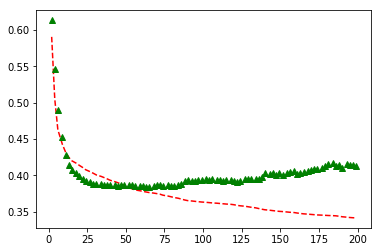

In [26]:
# 학습시킬 때마다 다른 결과가 나오기 때문에 Loss가 적어질때까지 여러 번 학습 시켜본다.
plt.plot(x_collect, train_loss_collect, "r--")
plt.plot(x_collect, valid_loss_collect, "g^")
plt.show()

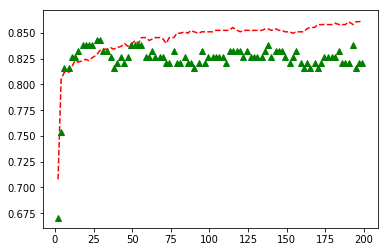

In [27]:
plt.plot(x_collect, train_acc_collect, "r--")
plt.plot(x_collect, valid_acc_collect, "g^")
plt.show()

Test Loss 구하기

In [28]:
model = build_neural_network()
restorer = tf.train.Saver()
with tf.Session() as sess:
    restorer.restore(sess,"./titanic.ckpt")
    feed = {
        model.inputs: test_data,
        model.is_training: False
    }
    test_predict = sess.run(model.predicted, feed_dict = feed)
    
test_predict[:10]

INFO:tensorflow:Restoring parameters from ./titanic.ckpt


ValueError: could not convert string to float: 'C'

In [ ]:
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(0.5)
test_predict_result = binarizer.fit_transform(test_predict)
test_predict_result = test_predict_result.astype(np.int32)
test_predict_result[:10]

In [ ]:
passenger_id = test_passenger_id.copy()
evaluation = passenger_id.to_frame()
evaluation["Survived"] = test_predict_result
evaluation[:10]

In [ ]:
evaluation.to_csv("submission/tf_submission.csv",index=False)